In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import seaborn as sns
from scipy.stats import ttest_1samp
import sys
sys.path.append('..')
from helpers.funcs import *

In [17]:
config = json.load(open('../config.json', 'r'))
INPUT_DIR = config['INPUT_DIR']
OUTPUT_DIR = config['OUTPUT_DIR']
TWEET_DIR = config['TWEET_DIR']
NUM_CLUSTERS = config['NUM_CLUSTERS']
cluster_names = {v:k for k, v in config['CLUSTER_NAMES'].items()}

In [12]:
events = open(INPUT_DIR + 'event_names.txt', 'r').read().splitlines()
shooter_race = json.load(open(INPUT_DIR + "shooters_race.json","r"))

In [13]:
def split_party(part_tweets):
    return part_tweets[part_tweets['dem_follows'] > part_tweets['rep_follows']], part_tweets[part_tweets['dem_follows'] < part_tweets['rep_follows']]

In [21]:
def get_odds(tweets,  search):
    total = len(tweets)
    contains = tweets['text'].str.contains(search, case=False).sum()
    return (contains + 1) / ((total - contains) + 1)

In [5]:
modal_list = []
log_odds_list = []
race = []

for event in events:
    print(event)
    data = pd.read_csv(TWEET_DIR +event+'/'+event+'.csv', sep='\t', lineterminator='\n', usecols=['text', 'rep_follows', 'dem_follows', 'remove', 'isRT'])
    # data['text'].str.contains(r'http|\.com|www', case=False)
    data = filter_retweets(data)
    # get partisan tweets
    data = data[~data['dem_follows'].isnull() & ~data['rep_follows'].isnull() & (data['dem_follows'] != data['rep_follows'])]
    dem, rep = split_party(data)
    modal_list.append('MUST')
    log_odds_list.append(np.log(get_odds(rep, r"\bmust[n'’]?\w*\b") / get_odds(dem, r"\bmust[n'’]?\w*\b")))
    race.append(shooter_race[event])
    modal_list.append('SHOULD')
    log_odds_list.append(np.log(get_odds(rep, r"\bshould[n'’]?\w*\b") / get_odds(dem, r"\bshould[n'’]?\w*\b")))
    race.append(shooter_race[event])
    modal_list.append('NEED TO')
    log_odds_list.append(np.log(get_odds(rep, r"\bneed to\b|\bneeds to\b") / get_odds(dem, r"\bneed to\b|\bneeds to\b")))
    race.append(shooter_race[event])    
    modal_list.append('HAVE TO')
    log_odds_list.append(np.log(get_odds(rep, r"\bhas to\b|\bhave to\b") / get_odds(dem, r"\bhas to\b|\bhave to\b")))
    race.append(shooter_race[event])
    

chattanooga
roseburg
colorado_springs
san_bernardino
kalamazoo
orlando
dallas
baton_rouge
burlington
fort_lauderdale
fresno
san_francisco
vegas
thornton
sutherland_springs
parkland
nashville
santa_fe
annapolis
pittsburgh
thousand_oaks


In [6]:
df = pd.DataFrame.from_dict({'modal':modal_list, 'log_odds':log_odds_list, 'race':race})

In [7]:
for i, g in df.groupby('modal'):
    print(i)
    print(ttest_1samp(np.array(g['log_odds']), 0))

HAVE TO
Ttest_1sampResult(statistic=-6.608889419465189, pvalue=1.9483181505360368e-06)
MUST
Ttest_1sampResult(statistic=-4.203676418304983, pvalue=0.00043694623689948805)
NEED TO
Ttest_1sampResult(statistic=-3.033095955178946, pvalue=0.0065672893980417086)
SHOULD
Ttest_1sampResult(statistic=-3.0886248018459046, pvalue=0.005792319868196137)


In [8]:
df.groupby('modal').median().sort_values('log_odds')

,log_odds
modal,
HAVE TO,-0.392316
MUST,-0.209859
SHOULD,-0.161042
NEED TO,-0.128364


In [9]:
df.groupby('modal').mean().sort_values('log_odds')

,log_odds
modal,
HAVE TO,-0.385567
MUST,-0.276668
SHOULD,-0.184487
NEED TO,-0.177741


[None, None]

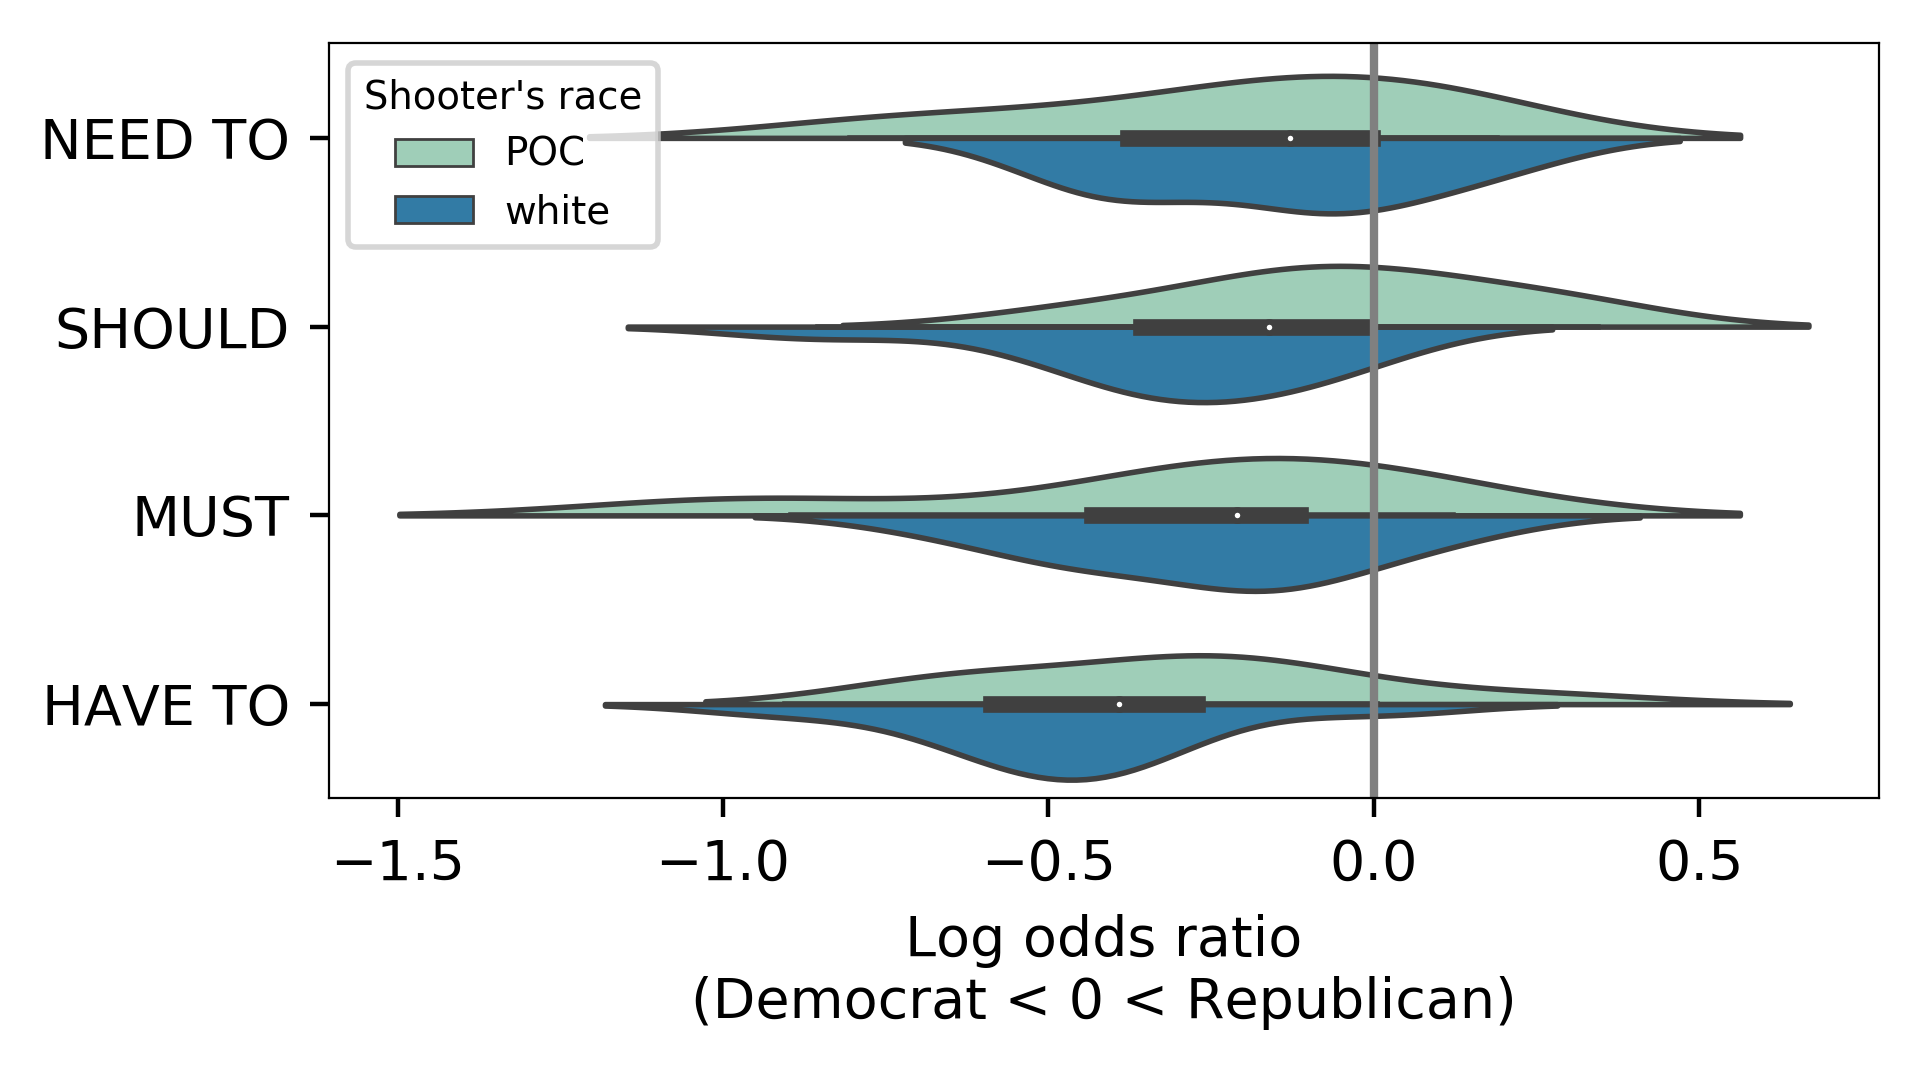

In [10]:
f = plt.figure(dpi=400, figsize=(5,2.5))
ax = sns.violinplot(data=df, x="log_odds",y="modal", hue='race', fliersize=1, linewidth=1, split=True, order=reversed(df.groupby('modal').median().sort_values('log_odds').index), orient="h", palette=sns.color_palette("YlGnBu", 2))
ax.set_ylabel('')
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
plt.axvline(x=0, color='grey')
ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')
legend = ax.legend(loc='upper left', title="Shooter's race", fontsize=7)
plt.setp(legend.get_title(),fontsize='x-small')

# distribution of modals across topics

In [16]:
modal_list = []
topic_list = []
value_list = []
event_list = []

def print_distr(event, name, s, total_props):
    print(name)
    b = np.bincount(s['topic'])
    vals = (b / np.sum(b)) / total_props
    #print(((b / np.sum(b)) / total_props))
    for i in range(NUM_CLUSTERS):
        topic_list.append(cluster_names[i])
        value_list.append(vals[i])
        modal_list.append(name)
        event_list.append(event)
        

for event in events:
    print(event)
    data = pd.read_csv(TWEET_DIR + event + '/' + event + '.csv', sep='\t', lineterminator='\n',
                       usecols=['user_id', 'text'])
    data = get_cluster_assignments(event, data, 'relative')
    total_props = np.bincount(data['topic']) / np.sum(np.bincount(data['topic']))

    s = data[data['text'].str.contains(r"\bmust[n'’]?\w*\b", case=False)]
    try:
        print_distr(event, 'MUST', s, total_props)
    except:
        pass
    
    s = data[data['text'].str.contains(r"\bshould[n'’]?\w*\b", case=False)]
    try:
        print_distr(event, 'SHOULD', s, total_props)
    except:
        pass
    
    s = data[data['text'].str.contains(r"\bneed to\b|\bneeds to\b", case=False)]
    try:
        print_distr(event, 'NEED TO', s, total_props)
    except:
        pass
    s = data[data['text'].str.contains(r"\bhas to\b|\bhave to\b", case=False)]
    try:
        print_distr(event, 'HAS TO', s, total_props)
    except:
        pass
    
    #s = data[data['text'].str.contains(r"\bcan[n'’]?\w*\b", case=False)]
    #try:
    #    print_distr(event, 'CAN', s, total_props)
    #except:
    #    pass

chattanooga
MUST
SHOULD
NEED TO
HAS TO
roseburg
MUST
SHOULD
NEED TO
HAS TO
colorado_springs
MUST
SHOULD
NEED TO
HAS TO
san_bernardino
MUST
SHOULD
NEED TO
HAS TO
kalamazoo
MUST
SHOULD
NEED TO
HAS TO
orlando
MUST
SHOULD
NEED TO
HAS TO
dallas
MUST
SHOULD
NEED TO
HAS TO
baton_rouge
MUST
SHOULD
NEED TO
HAS TO
burlington
MUST
SHOULD
NEED TO
HAS TO
fort_lauderdale
MUST
SHOULD
NEED TO
HAS TO
fresno
MUST
SHOULD
NEED TO
HAS TO
san_francisco
MUST
SHOULD
NEED TO
HAS TO
vegas
MUST
SHOULD
NEED TO
HAS TO
thornton
MUST
SHOULD
NEED TO
HAS TO
sutherland_springs
MUST
SHOULD
NEED TO
HAS TO
parkland
MUST
SHOULD
NEED TO
HAS TO
nashville
MUST
SHOULD
NEED TO
HAS TO
santa_fe
MUST
SHOULD
NEED TO
HAS TO
annapolis
MUST
SHOULD
NEED TO
HAS TO
pittsburgh
MUST
SHOULD
NEED TO
HAS TO
thousand_oaks
MUST
SHOULD
NEED TO
HAS TO


In [18]:
df = pd.DataFrame.from_dict({'modal':modal_list, 'proportion':value_list, 'topic':topic_list, 'event':event_list})

In [19]:
df.to_csv(OUTPUT_DIR + 'modal_distributions.csv')

In [20]:
df

,modal,proportion,topic,event
0,MUST,1.279851,shooter's identity\n& ideology,chattanooga
1,MUST,0.538147,news,chattanooga
2,MUST,0.000000,victims & location,chattanooga
3,MUST,2.323887,laws & policy,chattanooga
4,MUST,0.968246,investigation,chattanooga
5,MUST,0.756667,solidarity,chattanooga
6,MUST,0.559113,remembrance,chattanooga
7,MUST,0.664835,other,chattanooga
8,SHOULD,0.705059,shooter's identity\n& ideology,chattanooga
9,SHOULD,0.142320,news,chattanooga


# modality & tense

In [37]:
shouldve_odds = []
not_shouldve_odds = []
prop_shouldve = []
race = []


for event in events:
    print(event)
    data = pd.read_csv(TWEET_DIR +event+'/'+event+'.csv', sep='\t', lineterminator='\n', usecols=['text', 'rep_follows', 'dem_follows', 'remove', 'isRT'])
    # data['text'].str.contains(r'http|\.com|www', case=False)
    data = filter_retweets(data)
    # get partisan tweets
    data = data[~data['dem_follows'].isnull() & ~data['rep_follows'].isnull() & (data['dem_follows'] != data['rep_follows'])]
    dem, rep = split_party(data)
    search = r"\bshould['’]ve\b|\bshould( not)? have\b|\bshouldn['’]t have\b"
    search_not_shouldve = r"\bshouldn['’]t(?! have)\b|\bshould\b[^'’](?!have)"
    shouldve_odds.append(np.log(get_odds(rep, search) / get_odds(dem, search)))
    not_shouldve_odds.append(np.log(get_odds(rep, search_not_shouldve) / get_odds(dem, search_not_shouldve)))
    prop = data['text'].str.contains(search, case=False).sum() / data['text'].str.contains(r"\bshould[n'’]?\w*\b", case=False).sum()
    prop_shouldve.append(prop)
    race.append(shooter_race[event])

chattanooga


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


roseburg


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


colorado_springs


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


san_bernardino


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


kalamazoo
orlando


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has ma

dallas


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


baton_rouge


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


burlington
fort_lauderdale


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has ma

fresno
san_francisco


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


vegas


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


thornton


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


sutherland_springs


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


parkland


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


nashville


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


santa_fe


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


annapolis


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


pittsburgh


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


thousand_oaks


/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [38]:
df = pd.DataFrame.from_dict({'shouldve_prop':prop_shouldve, 'shouldve_odds':shouldve_odds, 'not_shouldve_odds':not_shouldve_odds, 'race':race})

array([<matplotlib.axes._subplots.AxesSubplot object at 0x123e87278>,
      dtype=object)

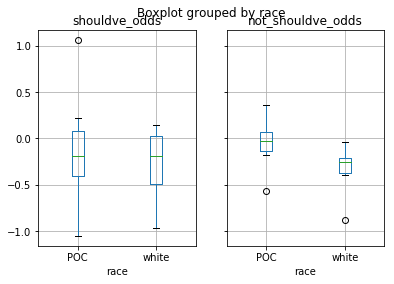

In [43]:
df.boxplot(column=['shouldve_odds', 'not_shouldve_odds'], by='race')

In [36]:
print(ttest_1samp(df['log_odds'], 0))
for i, g in df.groupby('race'):
    print(i, ttest_1samp(g['log_odds'], 0))

Ttest_1sampResult(statistic=-2.0879975088054836, pvalue=0.049797499455887545)
POC Ttest_1sampResult(statistic=-0.9294853187442579, pvalue=0.3768942932853042)
white Ttest_1sampResult(statistic=-2.3975649783673476, pvalue=0.0374712176170982)


In [34]:
df

,shouldve_prop,log_odds,race
0,0.158664,0.151098,POC
1,0.152381,-0.247602,POC
2,0.113320,-0.534749,white
3,0.152174,-0.129056,POC
4,0.154362,-0.004500,white
5,0.160656,-0.217012,POC
6,0.129347,-0.158503,POC
7,0.120000,-0.941434,POC
8,0.142857,-1.052453,POC
9,0.122449,0.217787,POC
